In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import os
import random
import time

# Inside the /Multimodal-Deep-Regression/notebooks
import sys
sys.path.append("..")

from util.utilities import train, evaluate, get_device
from util.data_utilities import get_base_tensor_directories, generate_batch, get_train_and_val_loader, process_data

# import all the models from models module
from models import CNN3DClassifier

device = get_device()

You are using device: cuda


In [2]:
# process_data(
#     input_type='video_pack_1000', 
#     # addition_parameters={'first_n_videos': 5}, 
#     verbose=False,
#     device=get_device(),
#     skip_frames=True,
#     frames_to_skip=200,
#     resize_tensors=True,
#     # uniform_frames=True,
#     # set_frame_count=15,
#     shrink=8,
#     clean_dir=True
# )

In [3]:
device = get_device()
train_loader, val_loader = get_train_and_val_loader(
    input_type='video_pack_1000',
    batch_size=15,
    verbose=True,
    tensor_upper_limit=1000,
    target_type='classification'
)

You are using device: cpu
torch.Size([3, 2, 128, 72])
torch.Size([3, 15, 128, 72])
800
200


In [4]:
model = CNN3DClassifier(
    reduce_pool=8,
    filters=15,
    depth=30,
    dropout_rate=0.1
)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.9)
model = model.to(device)

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")

EPOCHS = 5

train_losses = []
val_losses = []

input_verbose = False


Total parameters: 1,666,204


In [5]:
start_time = time.time()

for epoch in range(EPOCHS):
    train_loss, avg_train_loss = train(model, train_loader, criterion, optimizer, device, verbose=input_verbose)
    val_loss, avg_val_loss = evaluate(model, val_loader, criterion, device, verbose=input_verbose)
    
    # record the losses
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    # print every num times epoch only
    num = 1
    if ((epoch+1) % num == 0) or epoch == 0:
        if epoch == 0:
            time_took = (time.time() - start_time) / 60
            print(f'First epoch took {time_took:.1f} minutes.')
        print(f'Epoch {epoch+1}/{EPOCHS}, Train_Loss: {train_loss:.2f}, Avg: {avg_train_loss:.2f}; Val_Loss: {val_loss:.2f}, Avg: {avg_val_loss:.2f}')


First epoch took 1.9 minutes.
Epoch 1/5, Train_Loss: 2099.24, Avg: 38.87; Val_Loss: 35.33, Avg: 2.52
Epoch 2/5, Train_Loss: 105.85, Avg: 1.96; Val_Loss: 32.13, Avg: 2.30
Epoch 3/5, Train_Loss: 69.16, Avg: 1.28; Val_Loss: 25.27, Avg: 1.81
Epoch 4/5, Train_Loss: 52.83, Avg: 0.98; Val_Loss: 26.51, Avg: 1.89
Epoch 5/5, Train_Loss: 51.35, Avg: 0.95; Val_Loss: 24.75, Avg: 1.77


In [15]:
# save model if better or not exists
model_weights = {'model_state_dict': model.state_dict(), 'val_loss': avg_val_loss}
weights_file = '../models/save/CNN_classifier_weights.pt'
if not os.path.isfile(weights_file):
    # save new
    torch.save(model_weights, weights_file)
elif model_weights['val_loss'] < torch.load(weights_file)['val_loss']:
    # replace
    torch.save(model_weights, weights_file)

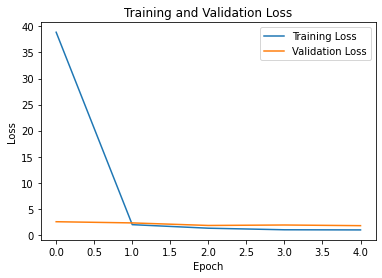

In [7]:
import matplotlib.pyplot as plt

# lost plot
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [8]:
# compare to validation set
val_values = []
predicted_values = []

for inputs, targets in val_loader:
    inputs, targets = inputs.to(torch.float32).to(device), targets.to(torch.float32).to(device)

    # Forward pass
    outputs = model(inputs)

    # Append the values
    val_values.extend(targets.tolist())
    predicted_values.extend(outputs.tolist())

In [9]:
import numpy as np

In [10]:
predicted_classes, true_classes = [], []
for i in range(len(predicted_values)):
    predicted_values_i = predicted_values[i]
    val_values_1 = val_values[i]

    prediction_prob = torch.nn.functional.softmax((torch.from_numpy(np.array(predicted_values_i))), dim=0)
    predicted_class = prediction_prob.argmax(dim=0).item()
    true_class = np.argmax(np.array(val_values_1))

    print(f'predicted class: {predicted_class}, true class: {true_class}')
    print(f'prediction prob: {prediction_prob}\n\n')

    predicted_classes.append(predicted_class)
    true_classes.append(true_class)


predicted class: 0, true class: 1
prediction prob: tensor([8.9966e-01, 9.7734e-02, 2.0565e-03, 5.5149e-04], dtype=torch.float64)


predicted class: 0, true class: 1
prediction prob: tensor([0.4304, 0.1102, 0.2125, 0.2470], dtype=torch.float64)


predicted class: 1, true class: 1
prediction prob: tensor([0.2802, 0.2919, 0.2256, 0.2023], dtype=torch.float64)


predicted class: 2, true class: 1
prediction prob: tensor([0.2851, 0.0950, 0.4889, 0.1311], dtype=torch.float64)


predicted class: 2, true class: 2
prediction prob: tensor([0.1934, 0.1178, 0.5161, 0.1727], dtype=torch.float64)


predicted class: 0, true class: 2
prediction prob: tensor([0.3111, 0.2406, 0.2249, 0.2233], dtype=torch.float64)


predicted class: 0, true class: 2
prediction prob: tensor([0.6349, 0.1167, 0.2236, 0.0248], dtype=torch.float64)


predicted class: 2, true class: 1
prediction prob: tensor([0.2493, 0.2363, 0.2690, 0.2454], dtype=torch.float64)


predicted class: 1, true class: 3
prediction prob: tensor([0.189

In [11]:
predicted_classes = torch.from_numpy(np.array(predicted_classes))
true_classes = torch.from_numpy(np.array(true_classes))

In [12]:
((predicted_classes == true_classes).sum() / true_classes.shape[0]).item()

0.2750000059604645

In [13]:
true_classes.numpy()

array([1, 1, 1, 1, 2, 2, 2, 1, 3, 3, 1, 2, 1, 0, 1, 1, 2, 2, 1, 0, 3, 0,
       3, 2, 1, 0, 0, 3, 1, 2, 2, 3, 0, 2, 0, 2, 1, 0, 1, 0, 2, 0, 1, 2,
       2, 2, 2, 1, 0, 1, 2, 1, 1, 1, 0, 1, 0, 3, 2, 1, 3, 0, 0, 2, 2, 3,
       0, 2, 0, 0, 3, 0, 0, 1, 3, 0, 1, 2, 2, 2, 1, 2, 2, 1, 3, 3, 2, 2,
       1, 2, 3, 3, 1, 0, 1, 1, 3, 1, 2, 2, 1, 2, 3, 2, 0, 3, 1, 1, 3, 2,
       3, 0, 2, 0, 2, 0, 3, 3, 2, 1, 1, 0, 1, 1, 1, 3, 3, 0, 2, 2, 1, 2,
       3, 2, 1, 2, 2, 2, 1, 0, 1, 0, 3, 1, 2, 3, 0, 2, 0, 1, 1, 1, 1, 2,
       3, 2, 3, 0, 3, 3, 2, 0, 2, 2, 3, 2, 1, 1, 3, 0, 0, 2, 0, 3, 0, 2,
       2, 0, 2, 0, 0, 0, 1, 1, 2, 1, 1, 2, 0, 0, 0, 2, 0, 1, 0, 1, 0, 3,
       2, 0])

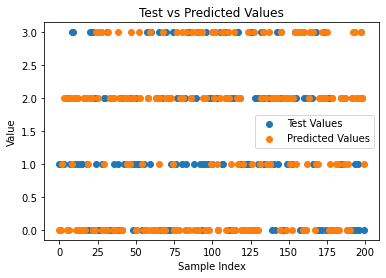

In [14]:
import matplotlib.pyplot as plt

plt.scatter(range(len(true_classes)), true_classes.numpy(), label='Test Values')
plt.scatter(range(len(true_classes)), predicted_classes.numpy(), label='Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.title('Test vs Predicted Values')
plt.legend()
plt.show()

In [6]:
model = CNN3DClassifier(
    reduce_pool=8,
    filters=15,
    depth=30,
    dropout_rate=0.1
)
model = model.to(device)
weights_file = '../models/save/CNN_classifier_weights.pt'
# load check point
model.load_state_dict(torch.load(weights_file)['model_state_dict'])

<All keys matched successfully>

In [7]:
train_loader, val_loader = get_train_and_val_loader(
    input_type='video_pack_100_holdout_swin',
    batch_size=20,
    verbose=True,
    target_type='classification'
)

torch.Size([3, 20, 128, 72])
torch.Size([3, 20, 128, 72])
80
20


In [8]:
import numpy as np

val_values = []
predicted_values = []

for inputs, targets in train_loader:
    model.eval()
    inputs, targets = inputs.to(torch.float32).to(device), targets.to(torch.float32).to(device)

    # Forward pass
    outputs = model(inputs)

    # Append the values
    val_values.extend(targets.tolist())
    predicted_values.extend(outputs.tolist())

for inputs, targets in val_loader:
    model.eval()
    inputs, targets = inputs.to(torch.float32).to(device), targets.to(torch.float32).to(device)

    # Forward pass
    outputs = model(inputs)

    # Append the values
    val_values.extend(targets.tolist())
    predicted_values.extend(outputs.tolist())

predicted_classes, true_classes = [], []
for i in range(len(predicted_values)):
    predicted_values_i = predicted_values[i]
    val_values_1 = val_values[i]

    prediction_prob = torch.nn.functional.softmax((torch.from_numpy(np.array(predicted_values_i))), dim=0)
    predicted_class = prediction_prob.argmax(dim=0).item()
    true_class = np.argmax(np.array(val_values_1))

    print(f'predicted class: {predicted_class}, true class: {true_class}')
    print(f'prediction prob: {prediction_prob}\n\n')

    predicted_classes.append(predicted_class)
    true_classes.append(true_class)

tensor([[ 1.3931,  0.9225,  0.9421,  1.2000],
        [ 2.8554,  2.7143,  3.0412,  2.1960],
        [ 1.4877,  1.4698,  1.0370,  2.5838],
        [ 2.0687,  2.0671,  2.7521,  2.3278],
        [ 2.2948,  0.9128,  1.1398,  1.7588],
        [ 1.3300,  1.2135,  1.6175,  1.6033],
        [ 1.7823,  1.8011,  2.3690,  2.1311],
        [ 2.1897,  0.6368,  0.6687,  1.8842],
        [ 1.4622,  1.0908,  1.1444,  1.1723],
        [ 2.5980,  1.3994,  1.7338,  2.7351],
        [ 0.9837,  0.7204,  1.0490,  1.3593],
        [ 2.4593,  2.3955,  2.4409,  3.8644],
        [ 1.5779,  1.5632,  1.6069,  2.3248],
        [ 1.2159,  1.5214,  1.5048,  1.9699],
        [ 4.2434,  0.7150,  4.0818,  3.2644],
        [ 7.6846,  1.4310,  1.2578,  5.3905],
        [-0.4422,  4.3923,  1.4683,  0.6896],
        [ 2.6552,  3.4658,  7.8650,  3.5614],
        [ 2.7538, -1.6006, 11.0711, -3.2341],
        [ 0.6887,  0.9644,  1.2180,  1.3378]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
tensor([[4.0769, 3.2381, 4.10

In [9]:
predicted_classes = torch.from_numpy(np.array(predicted_classes))
true_classes = torch.from_numpy(np.array(true_classes))

In [10]:
((predicted_classes == true_classes).sum() / true_classes.shape[0]).item()

0.30000001192092896